# Top-K Multi-Dimensional Motif and Matches Discovery

This tutorial builds on the [Multidimensional Motif Discovery](https://stumpy.readthedocs.io/en/latest/Tutorial_Multidimensional_Motif_Discovery.html) tutorial as it generalizes the search for a single multidimensional motif to multiple multidimensional motifs and their nearest neighbors (i.e. matches). We will show how the function `mmotifs`, which extends this advanced motif and match search, works by setting and explaining the different input parameters. The `mmotifs` function is the multidimensional analogue of the one-dimensional [motifs](https://github.com/TDAmeritrade/stumpy/blob/main/stumpy/motifs.py) function that can be found in the STUMPY API.

In [39]:
def show_motifs_matches(df, motifs_distances, motifs_indices, motifs_subspaces, motifs_mdls):
    num_motifs = motifs_distances.shape[0]

    for motif_num in range(num_motifs):
        motif_indices = motifs_indices[motif_num]
        mdl = motifs_mdls[motif_num]
        S = motifs_subspaces[motif_num]
        subspace = [df.columns.values[s] for s in S]

        k = len(S)
        f, axs = plt.subplots(k, 1, figsize=(20, 10), sharex=True)
        plt.suptitle(f"The {k}-dimensional motif")

        for j, s in enumerate(S):
            time_series = df[df.columns[s]]
            if k > 1:
                ax = axs[j]
            else:
                ax = axs
            ax.plot(time_series, c="0.75")
            ax.set_title(df.columns.values[s])

            motif_idx = motif_indices[0]
            nn_idx = motif_indices[1]
            ax.plot(time_series[motif_idx : motif_idx + m], c="r", linewidth=4)
            ax.plot(time_series[nn_idx : nn_idx + m], c="r", linewidth=4)
            # ax.axvline(x=motif_idx, linestyle='dashed', c='k', linewidth=2)
            # ax.axvline(x=nn_idx, linestyle='dashed', c='k', linewidth=2)

            # Only relevant if you want to find further matches
            # Set motif_indices[2:] to avoid double counting the motif pair
            [ax.plot(time_series[match : match + m], linewidth=3) for match in motif_indices[2:]]


## Getting started

Let's import the packages that we'll need to load, analyze, and plot the data.

In [40]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import stumpy
from stumpy import core
from stumpy.mmotifs import mmotifs

plt.style.use(
    "https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle"
)

## Loading, Preprocessing and Visualizing the Dataset

In the following we will take a look at the [Electrical Load Measurement](https://pureportal.strath.ac.uk/en/datasets/refit-electrical-load-measurements-cleaned) dataset, that consists of electrical load measurements for different appliances from households in the UK. To reduce the amount of data somewhat, we consider only the period from april 19 to may 15 of the year 2014. Also we want to take a closer look at only the five appliances `Fridge-Freezer`, `Freezer`, `Tumble Dryer`, `Diswasher` and `Washing Machine` and see if we are able to find meaningful motifs and matches on this multidimensional time series data! We simplify our life a bit more by converting the timestamps, which are sampled to 8 second intervals, to minutes in order to reduce the overall data size:

In [41]:
start_date, end_date = "2014-04-19", "2014-05-15"
df = pd.read_csv("../CLEAN_House3.csv")
df["Time"] = pd.to_datetime(df["Time"])
colnames = {
    "Appliance1": "Toaster",
    "Appliance2": "Fridge-Freezer",
    "Appliance3": "Freezer",
    "Appliance4": "Tumble Dryer",
    "Appliance5": "Dishwasher",
    "Appliance6": "Washing Machine",
    "Appliance7": "Television",
    "Appliance8": "Microwave",
    "Appliance9": "Kettle",
}
df = (
    df.rename(colnames, axis="columns")
    .loc[
        :,
        [
            "Time",
            "Fridge-Freezer",
            "Freezer",
            "Tumble Dryer",
            "Dishwasher",
            "Washing Machine",
        ],
    ]
    .query("Time >= @start_date and Time <= @end_date")
    .groupby(pd.Grouper(key="Time", freq="T"))
    .sum()
)

df.head()

,Fridge-Freezer,Freezer,Tumble Dryer,Dishwasher,Washing Machine
Time,,,,,
2014-04-19 00:00:00,0,0,0,0,0
2014-04-19 00:01:00,0,0,0,0,0
2014-04-19 00:02:00,0,0,0,0,0
2014-04-19 00:03:00,0,0,0,0,0
2014-04-19 00:04:00,0,0,0,0,0


The dataset now contains the time series of the five appliances with timestamps now sampled in minutes. Let's visualize it!

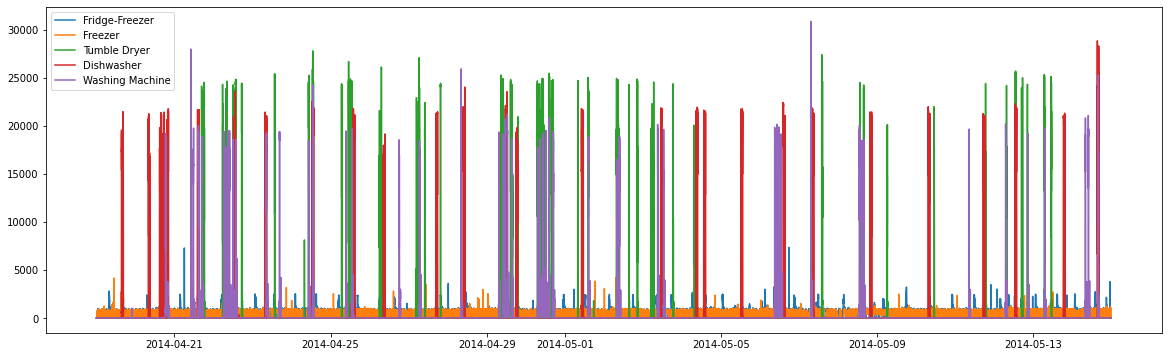

In [42]:
for colname in df.columns:
    plt.plot(df[colname], label=colname)
    plt.legend()

Unfortunately we first have to eliminate constant regions in order to find meaningful motifs.

In [43]:
# m was set to 4 hours
m = 4 * 60

np.random.seed(0)
padded_stddev = np.zeros(len(df))
for colname in df.columns:
    stddev = core.rolling_nanstd(df.loc[:, colname].values, m)
    padded_stddev[-len(stddev):] = stddev
    modified_values = df.loc[:, colname].where(padded_stddev != 0.0, np.nan)
    df = df.assign(**{colname: modified_values})
    # Apply noise to 0 regions
    noise = np.random.uniform(0.0, 0.1, size=len(df))
    zero_idx = df.loc[:, colname].where(df.loc[:, colname] != 0, noise)
    df = df.assign(**{colname: zero_idx})

Compute the mutli-dimensional matrix profile

Notice: Each row of the resultung array corresponds to each MP for a given dimension:

|Array|
|:-----:|
|_1D Matrix Profile_ $...$ |
|_2D Matrix Profile_ $...$ |
| $\vdots$ |
|_5D Matrix Profile_ $...$ |

the dimensionality of our last row containing all 5 appliances.

In [44]:
mps, indices = stumpy.mstump(df.astype(float), m)

## Discovering one motif and its matches

Find the motifs and matches with default parameters

In [45]:
motifs_distances, motifs_indices, motifs_subspaces, motifs_mdls = mmotifs(
    df.astype(float), mps, indices
)

Visualize motifs and matches with default parameters

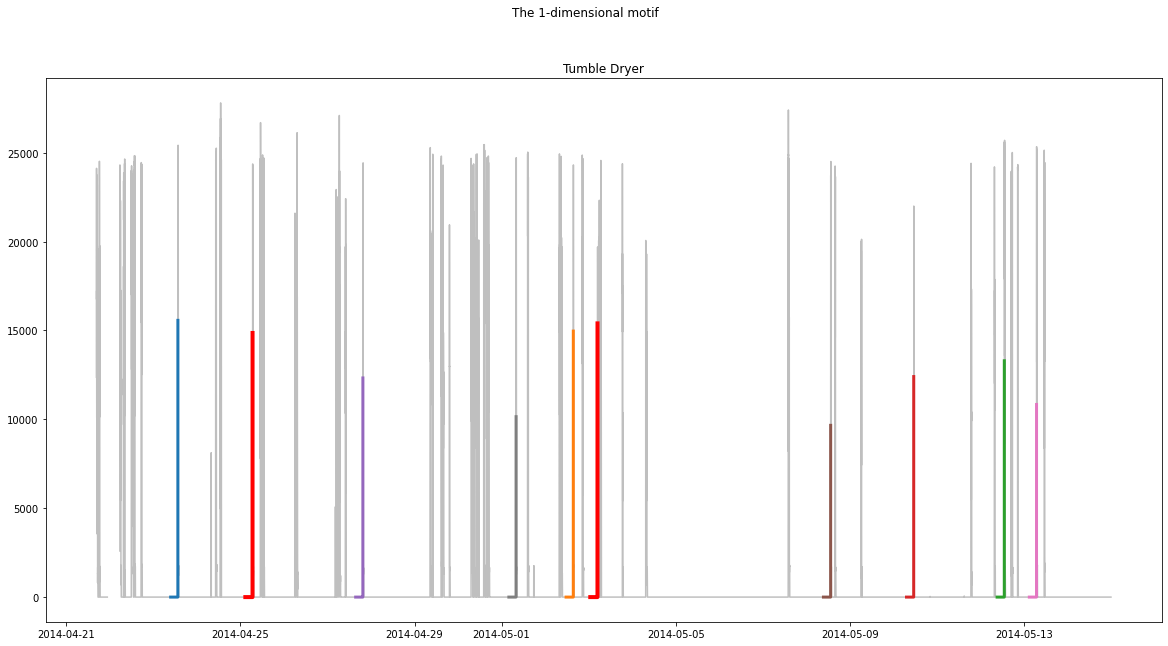

In [46]:
show_motifs_matches(df, motifs_distances, motifs_indices, motifs_subspaces, motifs_mdls)

Congratulations, you have found your first motif on the `Tumble Dryer` time series! We were able to find all 10 default matches with the motif pair (i. e. the two most similar subsequences) shown in red! 

But this doesn't have to be the case since the `max_distance` input parameter is computed automatically depending on the distance profile if not explicitly set otherwise. In this case the `max_distance` parameter was therefore bigger than all of the distances from the motif to its nine nearest neighbors and that's the reason why we were able to find all ten `max_matches`. The `max_matches` input parameter (which is set to 10 by default) is the maximum amount of similar matches (i.e. nearest neighbors) of a motif representative to be returned. But notice that the first match is always the self-match for each motif!

So what to do if we only want to get the motif pair without any further matches? That's easy! You only have to specifiy that you want to find two matches by setting the `max_matches` parameter and plot everything again:

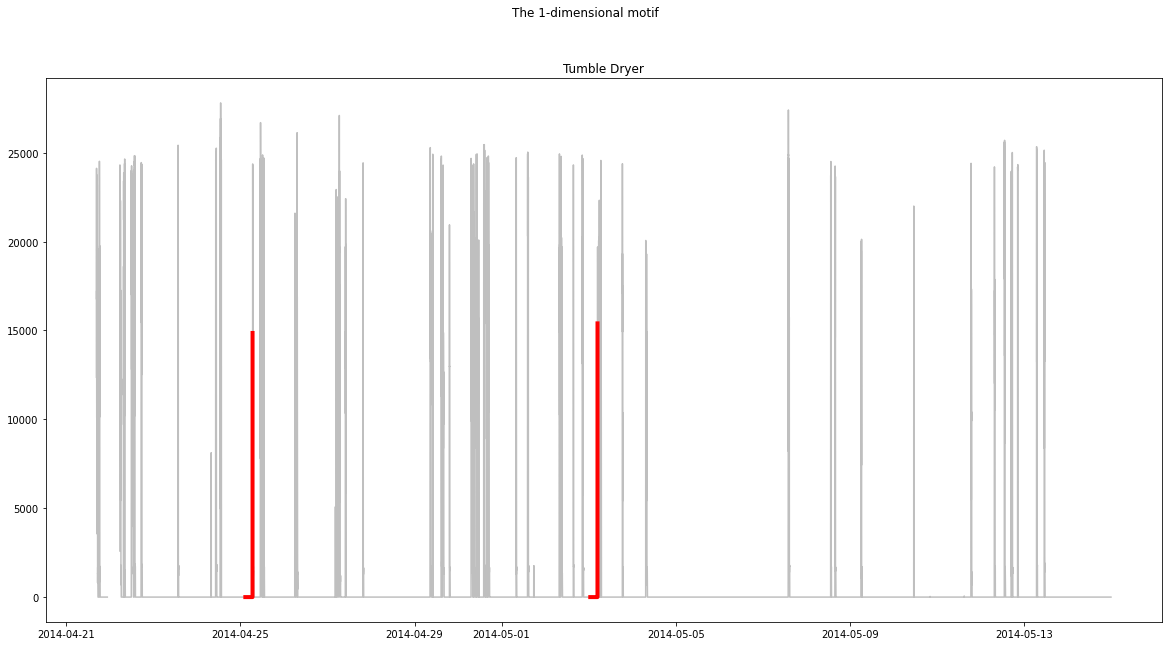

In [47]:
motifs_distances, motifs_indices, motifs_subspaces, motifs_mdls = mmotifs(
    df.astype(float), mps, indices, max_matches=2
)
show_motifs_matches(df, motifs_distances, motifs_indices, motifs_subspaces, motifs_mdls)

You proceed in the same way if, for example, you want to find the motif pair with its three nearest neighbors (i. e. `max_matches=5`)!
Tip: If you also set the maximal distance that is allowed between a motif and all other subeequences in the time series to infinite, you can make sure that you actually get exactly 5 matches and none less or more (even if not necessary here sice we were already able to find 10 matches)! So let's see how this works:

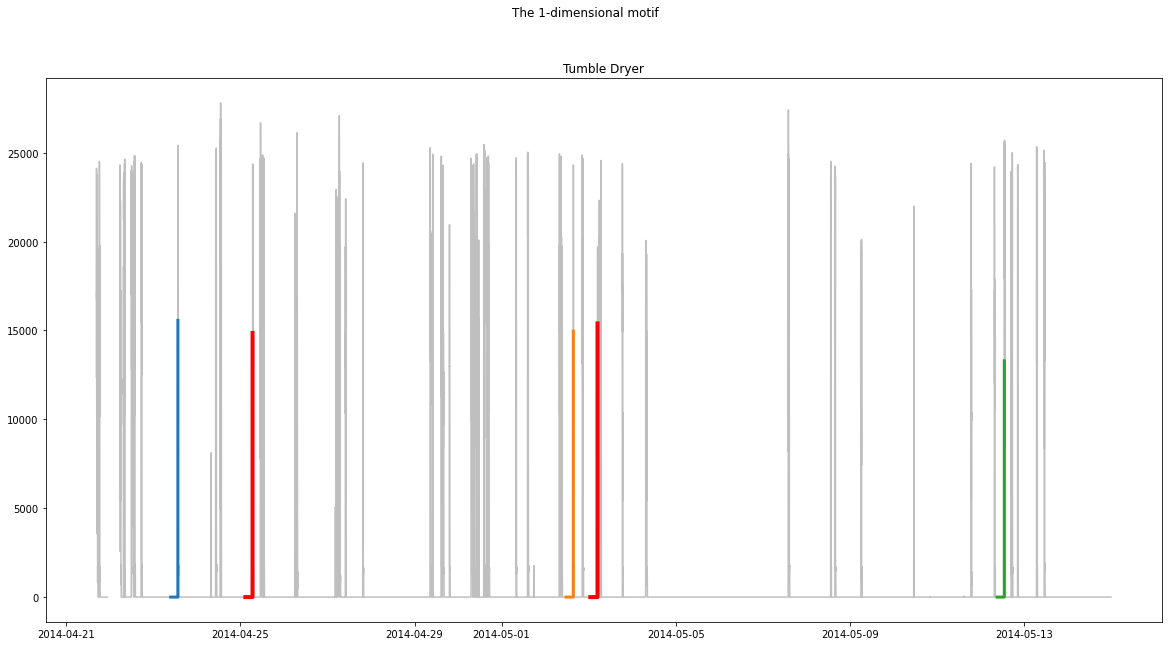

In [48]:
motifs_distances, motifs_indices, motifs_subspaces, motifs_mdls = mmotifs(
    df.astype(float), mps, indices, max_distance=np.inf, max_matches=5
)
show_motifs_matches(df, motifs_distances, motifs_indices, motifs_subspaces, motifs_mdls)

Plot MDL ...